Los modelos de difusión heredan de varias técnicas anteriormente vistas haciendo evolucionar una conjunto de ruido hacia una distribución conocida y acotada. Se trata de iniciar el proceso con algo aleatorio pero hacerlo converger a muestras de una distribución conocida como pudieran ser:

* Dígitos escritos a mano
* Ropa de un catalogo de moda

Aunque su aplicación inicial se dió en el contexto de la generación de imágenes, han sido utilizados para la creación de textos, particularmente código, con bastante éxito. Su fortaleza está en que el modelo no intenta hacer una generación en un único paso, lo cual facilita el entrenamiento pero también permite una mejor generación de imágenes con buena resolución.

Tenéis una muy buena referencia sobre esta temática en https://huggingface.co/learn/diffusion-course/unit0/1 aunque nosotros emplearemos un ejercicio simplificado que podéis extender con conceptos que van más en profundidad.

## Difusión

Se trata del proceso por el que podemos iniciar nuestro objeto de datos de forma aleatoria e ir regenerando una estructura sobre esa base que represente una distribución concreta.

![difusión](https://user-images.githubusercontent.com/10695622/174349667-04e9e485-793b-429a-affe-096e8199ad5b.png)

_Del artículo https://arxiv.org/abs/2006.11239_

La base consiste en la bidireccionalidad del proceso. Podemos empezar con imágenes de alta definición y calcular la forma en la que el ruido les es añadida. Esto nos permite generar un buen predictor de ruido que aplicado de manera inversa nos permite predecir que partes de una imagen son ruido, substraerlas y por pura iteración generar finalmente imágenes definidas de la distribución de las muestras originalmente presentadas.

![difusion](https://cdn.prod.website-files.com/614c82ed388d53640613982e/66acbdfb02fc228862686191_65608be75079ab1a96ef681b_reverse-sde.webp)

_Referencia_ https://arxiv.org/pdf/2011.13456

In [2]:
import tensorflow as tf

Trabajaremos con el conjunto de datos del CIFAR-10.

In [3]:
import matplotlib.pyplot as plt

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

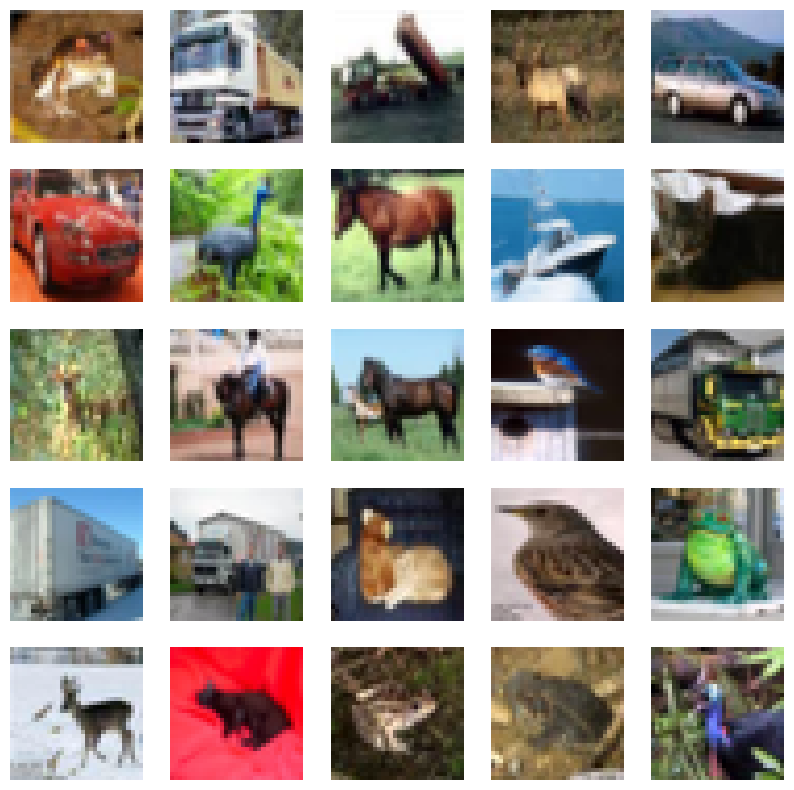

In [4]:
import numpy as np

def cvtImg(img):
    img = img - img.min()
    img = (img / img.max())
    return img.astype(np.float32)

def show_examples(x):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        img = cvtImg(x[i])
        plt.imshow(img)
        plt.axis('off')

show_examples(X_train)

In [5]:
X_train = X_train[y_train.squeeze() == 1]
X_train = (X_train / 127.5) - 1.0

Existe un profeso de secuenciado de la difusión que se conoce como planificador o _scheduler_ que es el encargado de hacer los pases por los bloques de difusión, creando la estructura arriba indicada que genera imágenes nítidas a partir del ruido.

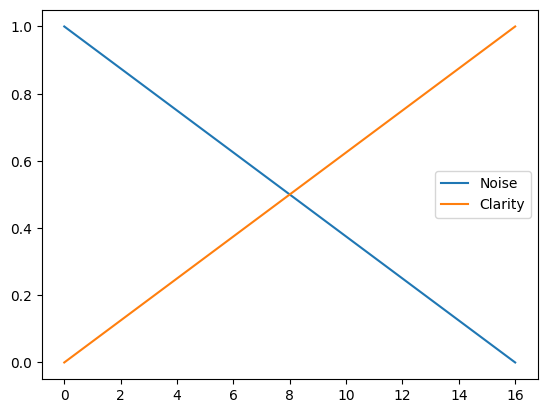

In [6]:
IMG_SIZE = 32     # input image size, CIFAR-10 is 32x32
BATCH_SIZE = 128  # for training batch size
timesteps = 16    # how many steps for a noisy image into clear
time_bar = 1 - np.linspace(0, 1.0, timesteps + 1) # linspace for timesteps

plt.plot(time_bar, label='Noise')
plt.plot(1 - time_bar, label='Clarity')
plt.legend();

In [7]:
def forward_noise(x, t):
    a = time_bar[t]      # base on t
    b = time_bar[t + 1]  # image for t + 1
    
    noise = np.random.normal(size=x.shape)  # noise mask
    a = a.reshape((-1, 1, 1, 1))
    b = b.reshape((-1, 1, 1, 1))
    img_a = x * (1 - a) + noise * a
    img_b = x * (1 - b) + noise * b
    return img_a, img_b
    
def generate_ts(num):
    return np.random.randint(0, timesteps, size=num)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


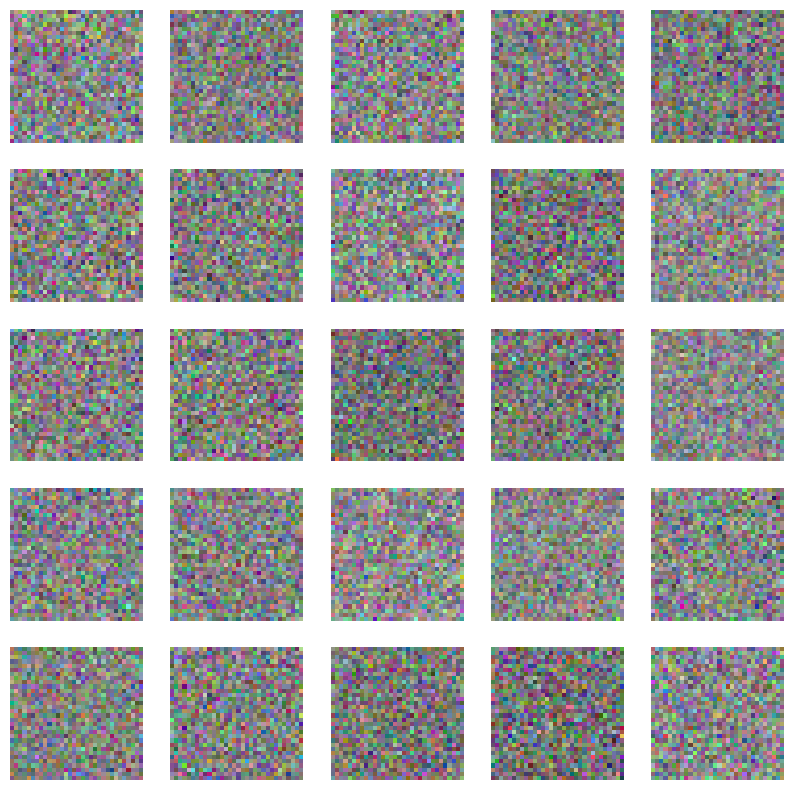

In [8]:
t = np.full((25,), 0) # El punto de partida
print(t)

a, b = forward_noise(X_train[:25], t)
show_examples(a)

[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15]


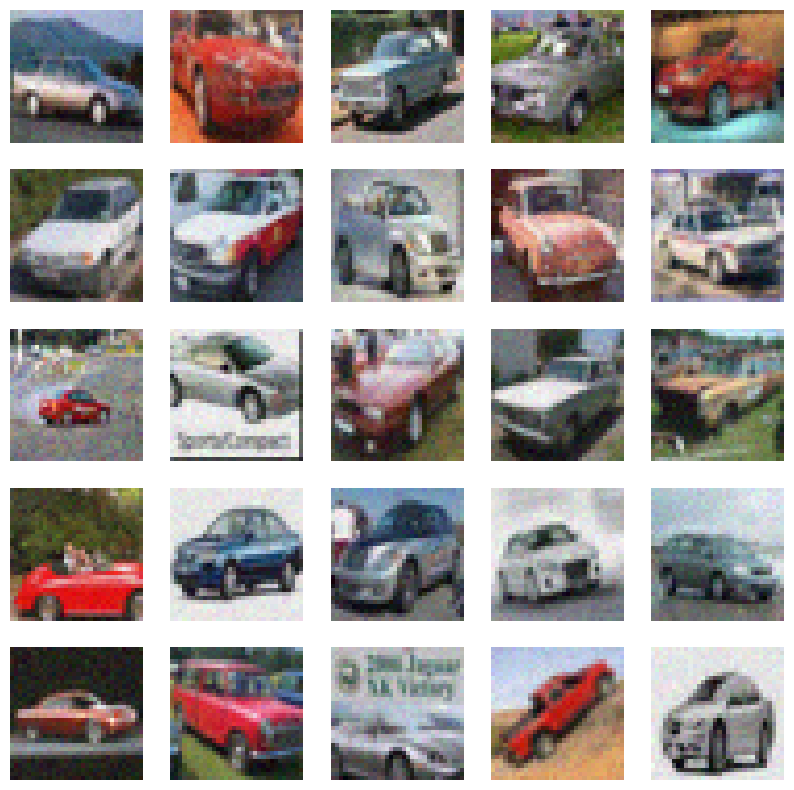

In [9]:
t = np.full((25,), timesteps - 1) # Damos todos los pasos, y generamos imágenes claras
print(t)

a, b = forward_noise(X_train[:25], t)
show_examples(a)

[11  4  7 11 15  3  2  5  8 14 15  5  5  8  1 14  3  0 13 10  2  5  1  0
 14]


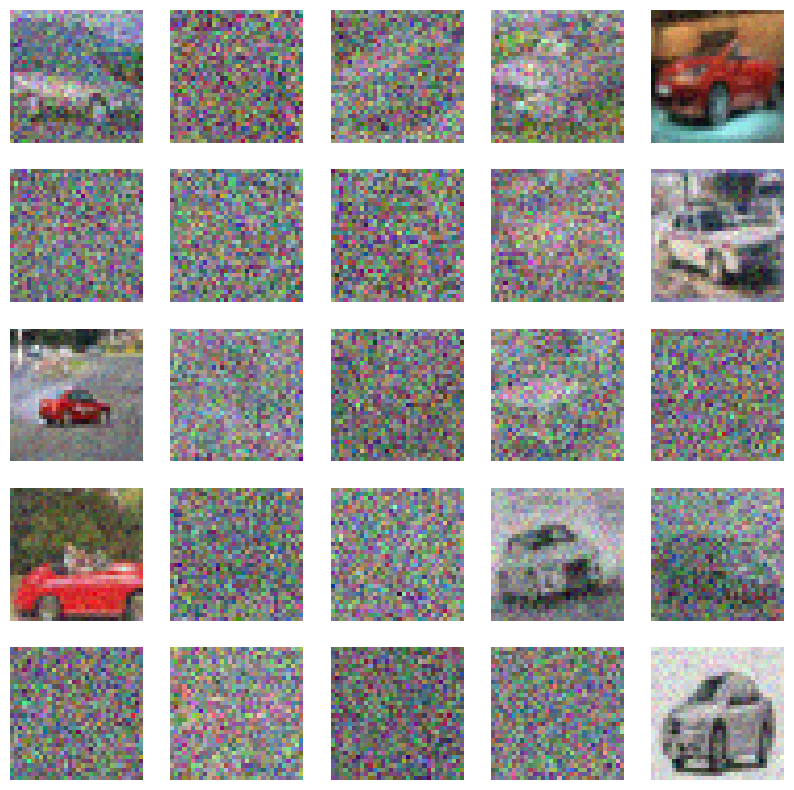

In [10]:
t = generate_ts(25)                 # intercalado
print(t)

a, b = forward_noise(X_train[:25], t)
show_examples(a)

Se observó que usar interpolaciones no lineales tiene sus ventajas, es quizás una de las grandes aportaciones del artículo de Stable Diffusion, y aunque el foco era la eficiencia, podemos ver cómo cambiar la forma en la que interpolamos ruido y señal también afecta al resultado:

![caras](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*CTM_483g1nWQLs8TGio6UQ.png)

https://arxiv.org/pdf/2112.10752

Con esto ahora nos toca diseñar nuestra red que tendrá una pinta similar a 

![Arquitectura de red](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [11]:
from keras import layers

def block(x_img, x_ts):
    x_parameter = layers.Conv2D(128, kernel_size=3, padding='same')(x_img)
    x_parameter = layers.Activation('relu')(x_parameter)

    time_parameter = layers.Dense(128)(x_ts)
    time_parameter = layers.Activation('relu')(time_parameter)
    time_parameter = layers.Reshape((1, 1, 128))(time_parameter)
    x_parameter = x_parameter * time_parameter
    
    x_out = layers.Conv2D(128, kernel_size=3, padding='same')(x_img)
    x_out = x_out + x_parameter
    x_out = layers.LayerNormalization()(x_out)
    x_out = layers.Activation('relu')(x_out)
    
    return x_out

In [15]:
def make_model():
    x_input = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='x_input')
    
    x_ts_input = layers.Input(shape=(1,), name='x_ts_input')
    
    x_ts = x_ts_input
    x_ts = layers.Dense(192)(x_ts)
    x_ts = layers.LayerNormalization()(x_ts)
    x_ts = layers.Activation('relu')(x_ts)
    
    x = x_input
    # ----- Hacia abajo -----
    x = x32 = block(x, x_ts)
    x = layers.MaxPool2D(2)(x)
    
    x = x16 = block(x, x_ts)
    x = layers.MaxPool2D(2)(x)
    
    x = x8 = block(x, x_ts)
    x = layers.MaxPool2D(2)(x)
    
    x = x4 = block(x, x_ts)
    
    # ----- MLP -----
    x = layers.Flatten()(x)
    x = layers.Concatenate()([x, x_ts])
    x = layers.Dense(128)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Dense(4 * 4 * 32)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Reshape((4, 4, 32))(x)
    
    # ----- Hacia arriba -----
    x = layers.Concatenate()([x, x4])
    x = block(x, x_ts)
    x = layers.UpSampling2D(2)(x)
    
    x = layers.Concatenate()([x, x8])
    x = block(x, x_ts)
    x = layers.UpSampling2D(2)(x)
    
    x = layers.Concatenate()([x, x16])
    x = block(x, x_ts)
    x = layers.UpSampling2D(2)(x)
    
    x = layers.Concatenate()([x, x32])
    x = block(x, x_ts)
    
    # ----- Salida -----
    x = layers.Conv2D(3, kernel_size=1, padding='same')(x)
    model = tf.keras.models.Model([x_input, x_ts_input], x)
    return model

model = make_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ x_ts_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 192)       │        384 │ x_ts_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 192)       │        384 │ dense_13[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_28       │ (None, 192)       │          0 │ layer_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ x_input             │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 128)       │     24,704 │ activation_28[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 32, 32,    │      3,584 │ x_input[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_30       │ (None, 128)       │          0 │ dense_14[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_29       │ (None, 32, 32,    │          0 │ conv2d_17[0][0]   │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_9 (Reshape) │ (None, 1, 1, 128) │          0 │ activation_30[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 32, 32,    │      3,584 │ x_input[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_8          │ (None, 32, 32,    │          0 │ activation_29[0]… │
│ (Multiply)          │ 128)              │            │ reshape_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 32, 32,    │          0 │ conv2d_18[0][0],  │
│                     │ 128)              │            │ multiply_8[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 32, 32,    │        256 │ add_8[0][0]       │
│ (LayerNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_31       │ (None, 32, 32,    │          0 │ layer_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ activation_31[0]… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 128)       │     24,704 │ activation_28[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 16, 16,    │    147,584 │ max_pooling2d_3[… │
│                     │ 128)              │            │                 

 Total params: 3,586,819 (13.68 MB)

 Trainable params: 3,586,819 (13.68 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0008)
loss_func = tf.keras.losses.MeanAbsoluteError()
model.compile(loss=loss_func, optimizer=optimizer)

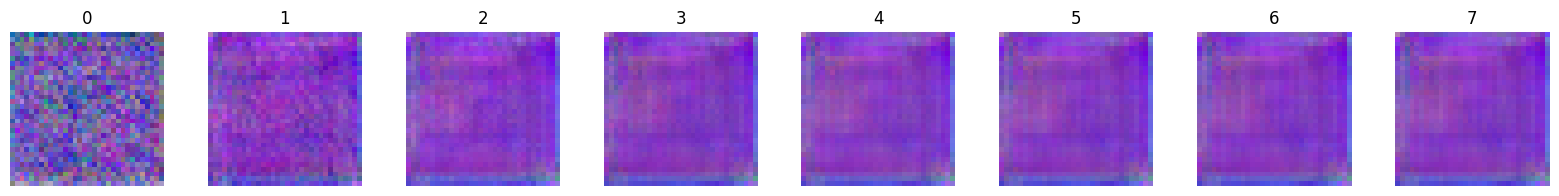

In [18]:
def predict_step():
    xs = []
    x = np.random.normal(size=(8, IMG_SIZE, IMG_SIZE, 3))

    for i in range(timesteps):
        t = i
        x = model.predict([x, np.full((8),  t)], verbose=0)
        if i % 2 == 0:
            xs.append(x[0])

    plt.figure(figsize=(20, 2))
    for i in range(len(xs)):
        plt.subplot(1, len(xs), i+1)
        plt.imshow(cvtImg(xs[i]))
        plt.title(f'{i}')
        plt.axis('off')

predict_step()

In [19]:
def train_one(x_img):
    x_ts = generate_ts(len(x_img))
    x_a, x_b = forward_noise(x_img, x_ts)
    loss = model.train_on_batch([x_a, x_ts], x_b)
    return loss

def train(R=50):
    total = 100
    for i in range(R):
        for j in range(total):
            x_img = X_train[np.random.randint(len(X_train), size=BATCH_SIZE)]
            loss = train_one(x_img)
            pg = (j / total) * 100
            if j % 20 == 0:
                print(f'iteration: {i} loss: {loss:.5f}, p: {pg:.2f}%')

def predict(x_idx=None):
    x = np.random.normal(size=(32, IMG_SIZE, IMG_SIZE, 3))
    for i in range(timesteps):
        t = i
        x = model.predict([x, np.full((32), t)], verbose=0)
    show_examples(x)

2025-07-15 09:17:07.652598: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2061', 328 bytes spill stores, 680 bytes spill loads

2025-07-15 09:17:08.093974: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3689', 668 bytes spill stores, 544 bytes spill loads

2025-07-15 09:17:08.451161: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3689', 580 bytes spill stores, 488 bytes spill loads

2025-07-15 09:17:08.682775: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3706', 720 bytes spill stores, 1240 bytes spill loads

2025-07-15 09:17:08.774072: I e

iteration: 0 loss: 1.05157, p: 0.00%
iteration: 0 loss: 0.57459, p: 20.00%
iteration: 0 loss: 0.40756, p: 40.00%
iteration: 0 loss: 0.32931, p: 60.00%
iteration: 0 loss: 0.28047, p: 80.00%
iteration: 1 loss: 0.24807, p: 0.00%
iteration: 1 loss: 0.22274, p: 20.00%
iteration: 1 loss: 0.20252, p: 40.00%
iteration: 1 loss: 0.18546, p: 60.00%
iteration: 1 loss: 0.17145, p: 80.00%
iteration: 2 loss: 0.15990, p: 0.00%
iteration: 2 loss: 0.15003, p: 20.00%
iteration: 2 loss: 0.14158, p: 40.00%
iteration: 2 loss: 0.13431, p: 60.00%
iteration: 2 loss: 0.12804, p: 80.00%
iteration: 3 loss: 0.12239, p: 0.00%
iteration: 3 loss: 0.11740, p: 20.00%
iteration: 3 loss: 0.11299, p: 40.00%
iteration: 3 loss: 0.10892, p: 60.00%
iteration: 3 loss: 0.10528, p: 80.00%
iteration: 4 loss: 0.10198, p: 0.00%
iteration: 4 loss: 0.09902, p: 20.00%
iteration: 4 loss: 0.09626, p: 40.00%
iteration: 4 loss: 0.09373, p: 60.00%
iteration: 4 loss: 0.09139, p: 80.00%
iteration: 5 loss: 0.08918, p: 0.00%
iteration: 5 loss:

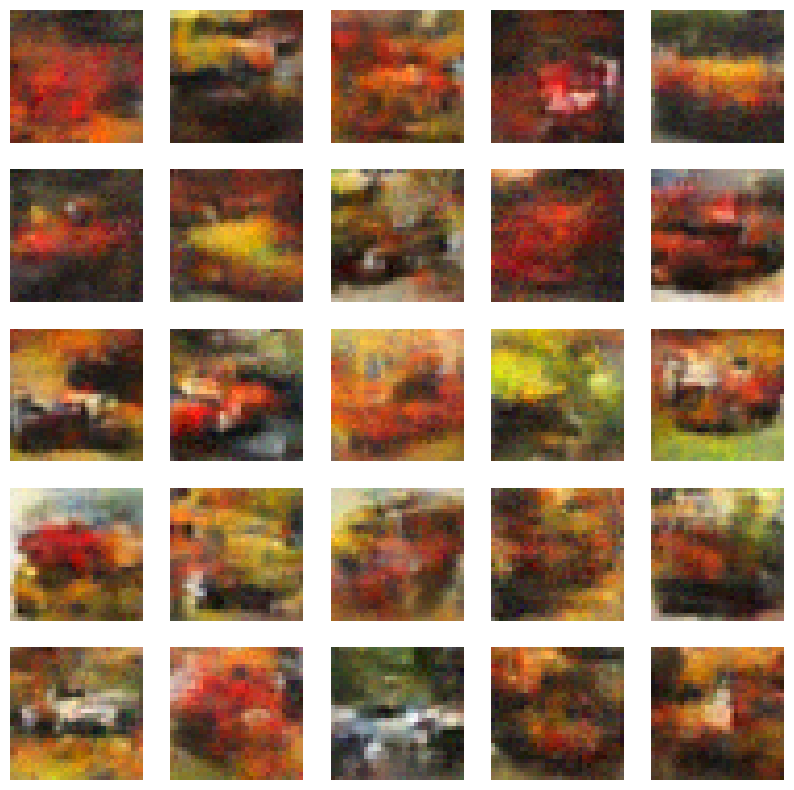

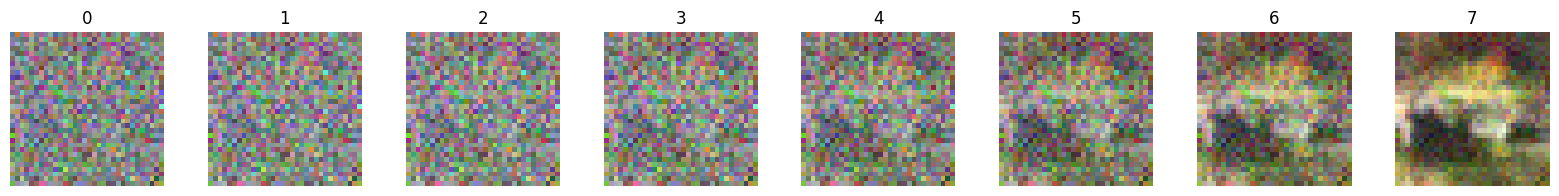

In [20]:
train()

# show result 
predict()
predict_step()
plt.show()

Podemos ajustar los parámetros de aprendizaje en cada iteración.

iteration: 0 loss: 0.03360, p: 0.00%
iteration: 0 loss: 0.03356, p: 20.00%
iteration: 0 loss: 0.03353, p: 40.00%
iteration: 0 loss: 0.03349, p: 60.00%
iteration: 0 loss: 0.03345, p: 80.00%
iteration: 1 loss: 0.03341, p: 0.00%
iteration: 1 loss: 0.03338, p: 20.00%
iteration: 1 loss: 0.03334, p: 40.00%
iteration: 1 loss: 0.03330, p: 60.00%
iteration: 1 loss: 0.03327, p: 80.00%


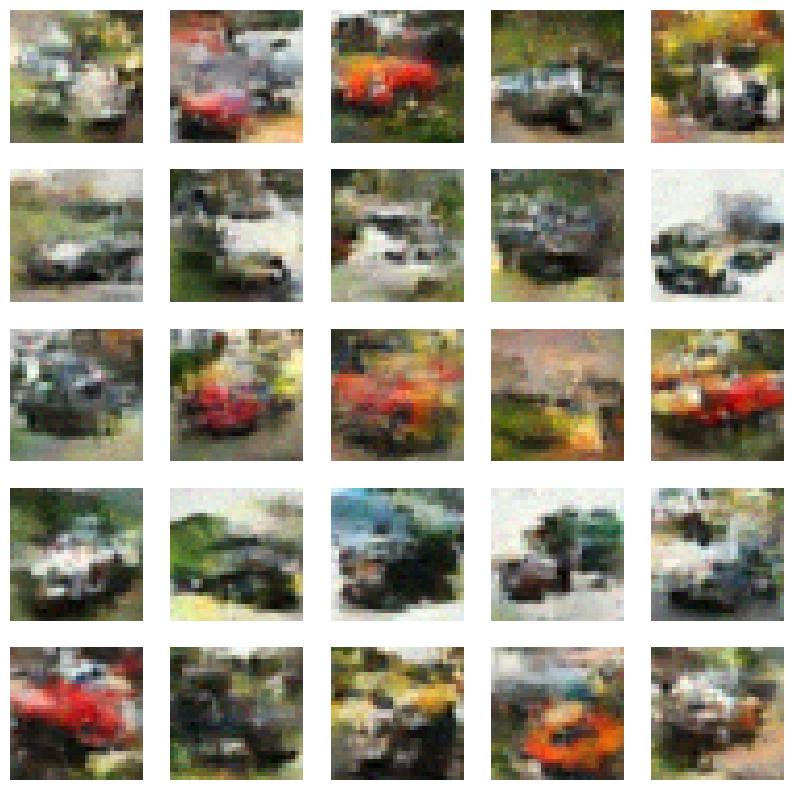

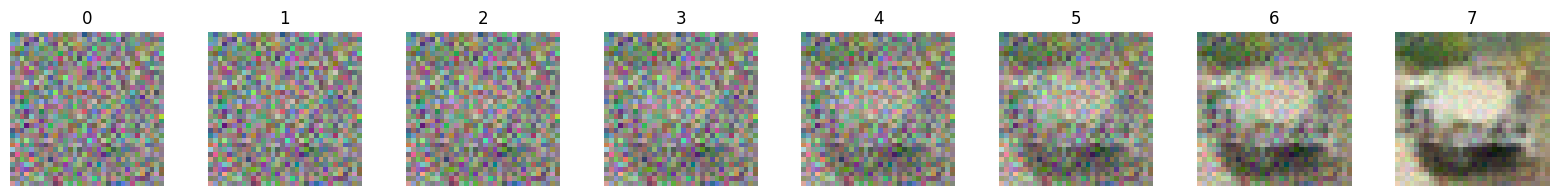

In [21]:
model.optimizer.learning_rate = max(0.000001, model.optimizer.learning_rate * 0.9)

train(2)
predict()
predict_step()
plt.show()

In [ ]:
model.save("modelos/difusion.keras")

Algunos recursos adicionales:

* https://github.com/CompVis/latent-diffusion
* https://huggingface.co/learn/diffusion-course/unit0/1